In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
import numpy as np

print(tf.__version__)
print(np.__version__)



2.0.0
1.18.3


# 数据集简介

In [2]:
mnist = np.load("mnist.npz")
x_train, y_train, x_test, y_test = mnist['x_train'],mnist['y_train'],mnist['x_test'],mnist['y_test']

x_train, x_test = x_train / 255.0, x_test / 255.0


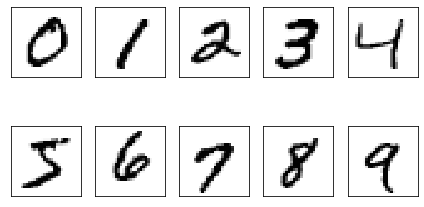

In [3]:
import matplotlib.pyplot as plt
 
fig, ax = plt.subplots(
    nrows=2,
    ncols=5,
    sharex=True,
    sharey=True, )
 
ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [4]:

# Add a channels dimension
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

y_train = tf.one_hot(y_train,depth=10)
y_test = tf.one_hot(y_test,depth=10)
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).shuffle(100).batch(32)



In [5]:

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


In [6]:
#返回的是一个正确的个数
#y_true
#y_pred
class CatgoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name='categorical_true_positives', **kwargs):
        super(CatgoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name='tp', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.argmax(y_pred,axis=-1)
        y_true = tf.argmax(y_true,axis=-1)
        values = tf.equal(tf.cast(y_true, 'int32'), tf.cast(y_pred, 'int32'))
        values = tf.cast(values, 'float32')
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, 'float32')
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        self.true_positives.assign(0.)


In [7]:

model = MyModel()
model.compile(optimizer = tf.keras.optimizers.Adam(0.001), #优化器
              loss =  tf.keras.losses.CategoricalCrossentropy(), #损失函数
              metrics = [tf.keras.metrics.CategoricalAccuracy(),
                         CatgoricalTruePositives(),
                        ]
             ) #评估函数


In [8]:

model.fit(train_ds, epochs=5,validation_data=test_ds)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/5
1875/1875 [==============================] - 179s 96ms/step - loss: 0.1335 - categorical_accuracy: 0.9598 - categorical_true_positives: 57587.0000 - val_loss: 0.0000e+00 - val_categorical_accuracy: 0.0000e+00 - val_categorical_true_positives: 0.0000e+00
Epoch 2/5
1875/1875 [==============================] - 177s 95ms/step - loss: 0.0428 - categorical_accuracy: 0.9869 - categorical_true_positives: 59215.0000 - val_loss: 0.0524 - val_categorical_accuracy: 0.9839 - val_categorical_true_positives: